### Band Pass Adjustment

https://hls.gsfc.nasa.gov/algorithms/bandpass-adjustment/


|Band Name | Slope | Offset | Residual |
|---|---|---|---|
|Coastal aerosol|0.996|-0.00023|0.0004|
|Blue|0.977|-0.00411|0.0018|
|Green|1.005|-0.00093|0.0011|
|Red|0.982|0.00094|0.0015|
|NIR|1.001|-0.00029|0.0003|
|SWIR 1|1.001|-0.00015|0.0001|
|SWIR 2|0.996|-0.00097|0.0009|

In [1]:
# Start client for multiprocessing

from dask.distributed import Client
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:53410 Dashboard: http://127.0.0.1:38886/status,Cluster Workers: 6 Cores: 24 Memory: 33.55 GB


In [28]:
client.close()

Exception ignored in: <generator object add_client at 0x7f8005f84468>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 179, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/comm/tcp.py", line 200, in read


In [1]:
# Geth the data 
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack
import xr_eotemp

saldana = regionstack.regionStack('Saldana_training_2015')
# Select dates

s2 = saldana.S2.sel(time='2015-12-21')

l8 = saldana.LC08.sel(time='2015-12-22')

In [3]:
# Select dates

s2 = saldana.S2.sel(time='2015-12-21')

l8 = saldana.LC08.sel(time='2015-12-22')

In [4]:
import numpy as np
import xarray as xr
import pandas as pd

time = xr.Variable('time', pd.DatetimeIndex(np.array([s2.time.values, l8.time.values])))
da = xr.concat([s2, l8], dim=time)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


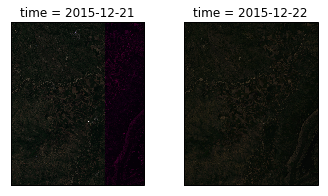

In [6]:
da.eotemp.plot_RGB()

In [ ]:
#import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 15, 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


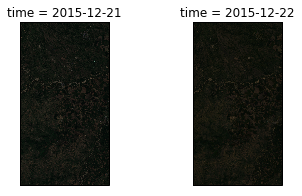

In [7]:
# Subset are with complete bands
xslice = (s2.x[0].values+0, s2.x[0].values+(s2.x[-1].values - s2.x[0].values)*2/3)
xslice

subset = da.sel(x=slice(xslice[0], xslice[1]))
subset.eotemp.plot_RGB()

Max: 1.5611
Min: 0.0145


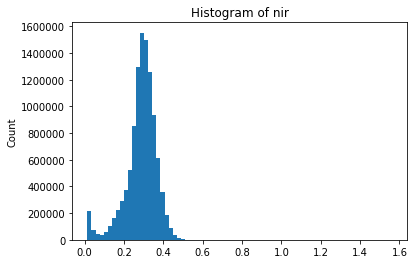

In [8]:
blue_vals = saldana.S2.isel(time=0).nir/10000
print('Max: {}'.format(blue_vals.max().compute().values))
print('Min: {}'.format(blue_vals.min().compute().values))
xr.plot.hist(blue_vals, bins=75)
None

In [20]:
from matplotlib import pyplot as plt

def correct_band(dataset, band):
    
    lf_dict = {'blue':[0.977, -0.00411],'green':[1.005, -0.00093],
               'red':[0.982, 0.00094],'nir':[1.001, -0.00029],
               'swir1':[1.001,-0.00015],'swir2':[0.996,-0.00097]}
    
    # Compute original difference
    orig_diff = (dataset[band].isel(time=0) - subset.blue.isel(time=1))*0.0001
    
    # Calculate error mean and sd
    orig_error_mean = orig_diff.mean(dim=['x','y']).compute()*0.0001
    orig_error_sd = orig_diff.std(dim=['x','y']).compute()*0.0001
    
    # Apply correction
    dataset[band+'_corr'] = lf_dict[band][0]*subset[band]+lf_dict[band][1]
    
    # Calculate the difference with corrected band 
    corr_diff = (dataset[band+'_corr'].isel(time=0) - dataset[band].isel(time=1))*0.0001
    
    corr_error_mean = corr_diff.mean(dim=['x','y']).compute()*0.0001
    corr_error_sd = corr_diff.std(dim=['x','y']).compute()*0.0001
    
    print('{} original: {} +- {}'.format(band, orig_error_mean.values+0, orig_error_sd.values*2))
    print('{} corected: {} +- {}'.format(band, corr_error_mean.values+0, corr_error_sd.values*2))
    
    # Plot differences
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (15, 10))
    # Histograms
    xr.plot.hist(orig_diff, bins=75, alpha=0.75, facecolor='blue', range=(-0.5,0.5), ax=axes[0,0])
    xr.plot.hist(corr_diff, bins=75, alpha=0.75, facecolor='green', range=(-0.5,0.5), ax=axes[0,1])
    # Maps
    orig_diff.plot(robust=True, ax=axes[1,0], cmap='viridis')
    corr_diff.plot(robust=True, ax=axes[1,1], cmap='viridis')
    
    #plt.title('{} band: original vs. corrected'.format(band))
    plt.tight_layout()
    plt.show()
    


red original: 2.5939178524353315e-06 +- 6.62145848826099e-06
red corected: -6.659136965043434e-09 +- 5.6575379714502355e-06


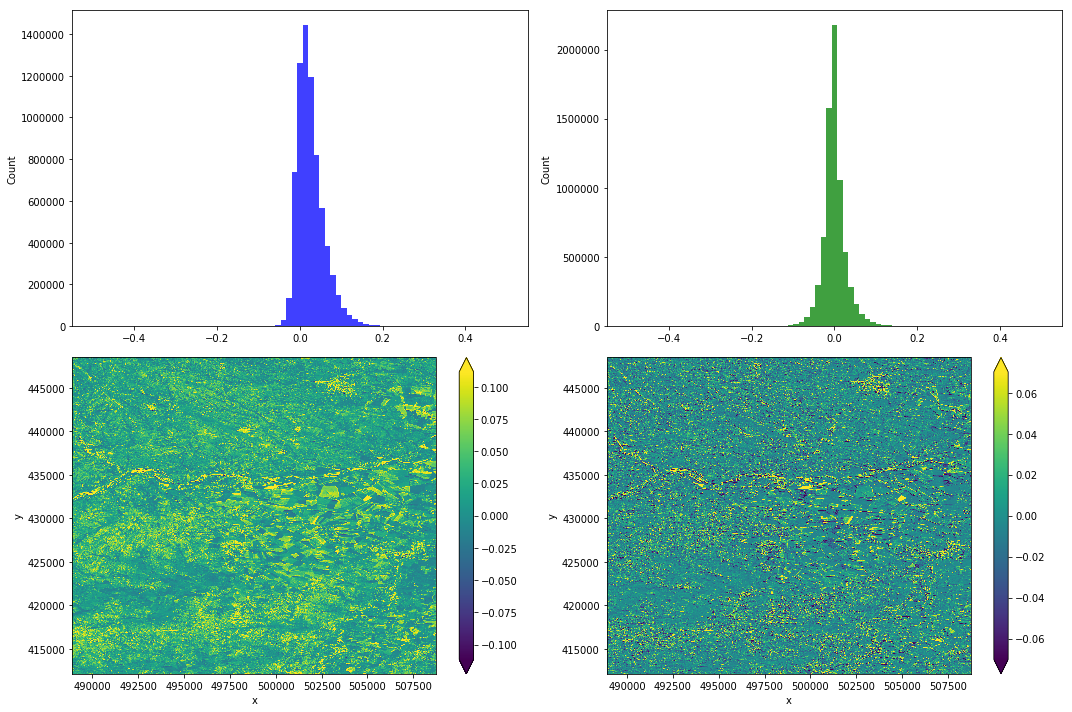

In [21]:
correct_band(subset, 'red')

green original: 3.6659047044146307e-06 +- 4.494529070792946e-06
green corected: 7.816268738318243e-07 +- 4.230510783360831e-06


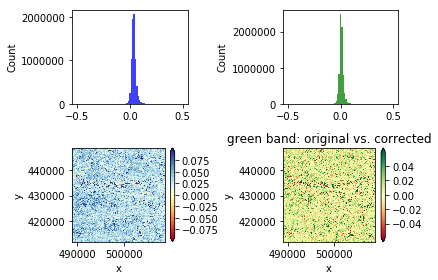

In [13]:
correct_band(subset, 'green')

blue original: 1.4751554885855716e-06 +- 3.840269358937844e-06
blue corected: 1.331035533347386e-06 +- 3.75703162963713e-06


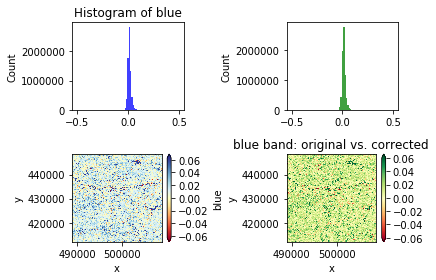

In [14]:
correct_band(subset, 'blue')

nir original: 2.3381695261757856e-05 +- 1.4637651979576061e-05
nir corected: -2.4254899245177393e-06 +- 9.110986588894559e-06


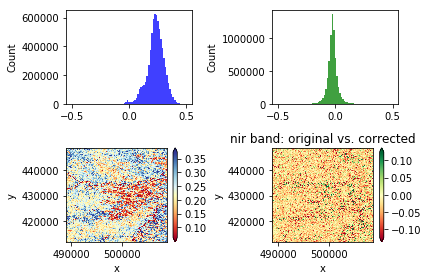

In [15]:
correct_band(subset, 'nir')

swir1 original: 2.084833787838643e-05 +- 1.2726453989387504e-05
swir1 corected: 1.6524475083535639e-06 +- 8.695640709259821e-06


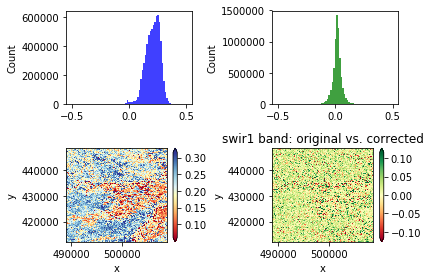

In [16]:
correct_band(subset, 'swir1')

swir2 original: 1.1242924429917308e-05 +- 1.0736412628397803e-05
swir2 corected: 1.9394820647470517e-06 +- 7.639673752072341e-06


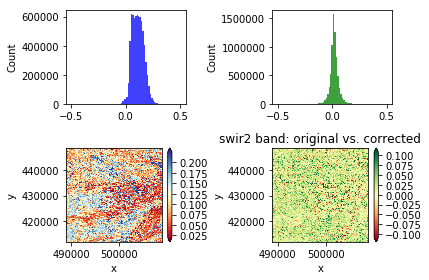

In [17]:
correct_band(subset, 'swir2')

### Check co-registration

In [102]:
import rasterio
import xarray as xr
import numpy as np
import pandas as pd
import os

def xarray_to_rasterio(xa, output_filename):
    """Converts the given xarray.DataArray object to a raster output file
    using rasterio.
    Arguments:
     - `xa`: The xarray.DataArray to convert
     - `output_filename`: the filename to store the output GeoTIFF file in
    Notes:
    Converts the given xarray.DataArray to a GeoTIFF output file using rasterio.
    This function only supports 2D or 3D DataArrays, and GeoTIFF output.
    The input DataArray must have attributes (stored as xa.attrs) specifying
    geographic metadata, or the output will have _no_ geographic information.
    If the DataArray uses dask as the storage backend then this function will
    force a load of the raw data.
    https://github.com/robintw/XArrayAndRasterio
    
    ---
    Modified coordinates of np.array using the affine attribute, flipping coordinates
    when coordinates are decreasing. Requires transposed array (y, x). TODO implement transpose
    
    """
    # Forcibly compute the data, to ensure that all of the metadata is
    # the same as the actual data (ie. dtypes are the same etc)
    xa = xa.load()

    if len(xa.shape) == 2:
        count = 1
        height = xa.shape[0]
        width = xa.shape[1]
        band_indicies = 1
    else:
        count = xa.shape[0]
        height = xa.shape[1]
        width = xa.shape[2]
        band_indicies = np.arange(count) + 1

    processed_attrs = {}

    # Get values to write
    bands_to_write = xa.values
    
    try:
        val = xa.attrs['affine']
        processed_attrs['affine'] = rasterio.Affine.from_gdal(*val)
        # Test if axes need to be inversed
        if val[1] < 0:
            bands_to_write = np.flip(bands_to_write, axis=2)
        if val[5] < 0:
            bands_to_write = np.flip(bands_to_write, axis=1)
    except KeyError:
        raise KeyError('affine attribute is not present in dataset')
    try:
        val = xa.attrs['crs']
        processed_attrs['crs'] = rasterio.crs.CRS.from_string(val)
    except KeyError:
        raise KeyError('crs attribute is not present in dataset')
    
    with rasterio.open(output_filename, 'w',
                       driver='GTiff',
                       height=height, width=width,
                       dtype=str(xa.dtype), count=count,
                       **processed_attrs) as dst:
        dst.write(bands_to_write, band_indicies)
        

In [55]:
def rename_variables(dataset,suffix,sep='_',ommit_vars=['time','x','y',]):
    """
    Method to rename variables of a dataset, ommiting the dimensions
    
    params:
        dataset (xarray.Dataset): dataset to rename
        suffix (str): suffix to append to the original name
        sep (str): string separator before suffix, defs to underscore
        
    returns:
        renamed dataset (xarray.Dataset)
    """
    # Get the original variable names
    variables = list(dataset.variables.keys())
    # Remove the dimension names    
    for var in list(dataset.dims.keys()):
        variables.remove(var)
    # Dictionary to map original and new names
    r_dict = {}
    # Populate dictionary with variable names to change
    list(map(lambda x: r_dict.update({x:x+sep+suffix}), variables))
    # Return renamed dataset
    return dataset.rename(r_dict)

In [25]:
l8 = rename_variables(l8, 'l8')
s2 = rename_variables(s2, 's2')

In [26]:
merged_ds = s2.merge(l8).transpose('y','x')

In [93]:
merged_ds.x.values[-1] - merged_ds.x.values[0]

29800.0

In [92]:
merged_ds.y.values[-1] - merged_ds.y.values[0]

36340.0

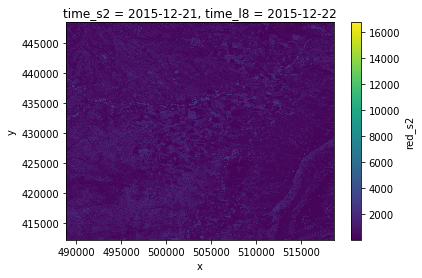

In [96]:
merged_ds.red_s2.plot()

In [35]:
bands = ['red','green','blue'] #xr.Variable('time', pd.DatetimeIndex(np.array([s2.time.values, l8.time.values])))
s2_array = xr.concat([merged_ds.red_s2, merged_ds.green_s2, merged_ds.blue_s2], dim=bands)
l8_array = xr.concat([merged_ds.red_l8, merged_ds.green_l8, merged_ds.blue_l8], dim=bands)
#rgb_array = xr.concat([merged_ds.red_l8, merged_ds.green_s2, merged_ds.blue_l8], dim=bands)

The methods needs some attributes to set the data array in a geographical

In [29]:
band_file = os.environ['WIN_SVR_DATA']+'Saldana/pre/-manually-relocated/S2A_MSIL2A_20180109T153101_N0206_R025_T18NVK_20180109T184834.data/B2.img'

bandwa = xr.open_rasterio(band_file)

GDAL transform

(c, a, b, f, d, e)

|Letter|Description|
|---|---|
|c | x-coordinate of the upper-left corner of the upper-left pixel |
|a | width of a pixel |
|b | row rotation (typically zero) |
|f | y-coordinate of the of the upper-left corner of the upper-left pixel |
|d | column rotation (typically zero) |
|e | height of a pixel (typically negative) |

In [34]:
crs = bandwa.attrs['crs']
print(crs)
transform = bandwa.attrs['transform']
print(transform)

+init=epsg:32618
(488900.0, 10.0, -0.0, 448460.0, -0.0, -10.0)


In [37]:
# Set crs and affine as attributes ## TODO change affine for transform?
s2_array.attrs['crs'] = crs
s2_array.attrs['affine'] = affine

# Call xarray to rasterio method
xarray_to_rasterio(s2_array, os.environ['WIN_SVR_DATA']+'file_name.tif')

### Interpolate values

In [2]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
from scipy import interpolate

stack_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/stack/'

files = list(map(lambda x: stack_dir+x, list(filter(re.compile('S2').search, os.listdir(stack_dir)))))

data_alt_chunk = xr.open_mfdataset(files, chunks={'x':1000,'y':1000}, parallel=True)

In [3]:
def build_temp_dyn(dataset, function):
    
    darray = dataset.stack(pixels = ['y', 'x']).squeeze()
    darray = darray.reset_coords(drop=True)
    
    ## Calculate times to interpolate
    times = calculate_time_periods(dataset.time.values)
    
    sp_int = darray.groupby('pixels').apply(function, times=times)
    sp_int_unstacked = sp_int.unstack('pixels')
    
    sp_int_unstacked['time'] = ('dim_0', pd.DatetimeIndex(times))
    sp_int_unstacked = sp_int_unstacked.rename({'pixels_level_0':'y',
                                               'pixels_level_1':'x',
                                               'dim_0':'time'})
    
    return sp_int_unstacked
    
    
def xr_cubic_spline(y, times):
    
    nans = np.isnan(y.values)[:,0]
    
    #print(y.values)
    #print(y.values.shape)
    
    spl = interpolate.CubicSpline(y.time.values.astype('d')[~nans],
                                  savitzky_golay(y.values[:,0][~nans],5,3))
    
    int_values = spl(times)
    
    return xr.DataArray(int_values)

def xr_cubic_spline_der(y, times):
    
    nans = np.isnan(y.values)[:,0]
    
    spl = interpolate.CubicSpline(y.time.values.astype('d')[~nans],
                                  savitzky_golay(y.values[:,0][~nans],5,3))
    
    der = spl.derivative()
    
    int_values = der(times)
    
    return xr.DataArray(int_values)

def calculate_time_periods(times):
    
    tdf = []
    
    # Todo make sure are ordered
    time = times[-1]
    min_time = times[0]
    
    while time > min_time:
        tdf.append(time)
        time -= np.timedelta64(16, 'D')
    
    #ts = (tdf - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 'D')
    
    return list(map(lambda x: x.astype('d'), tdf))

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


In [13]:
ndvi = data_alt_chunk.NDVI.sortby('time')
ndvi

<xarray.DataArray 'NDVI' (time: 8, y: 3631, x: 2979)>
dask.array<shape=(8, 3631, 2979), dtype=float32, chunksize=(8, 1000, 1000)>
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(3, 1000, 1000)>
Attributes:
    crs:                       +init=epsg:32618
    header_offset:             0
    data_type:                 4
    nodatavals:                nan
    file_type:                 ENVI Standard
    res:                       [10. 10.]
    lines:                     3631
    transform:                 [ 4.8890e+05  1.0000e+01 -0.0000e+00  4.4846e+...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_18N",GEOGCS["GCS_WGS...
    interleave:                bsq
    is_tiled:         

In [14]:
subset = ndvi.where(ndvi.mask).isel(x=slice(1300,1400),y=slice(1500,1600))
subset = subset.load()

In [15]:
subset

<xarray.DataArray (time: 8, y: 100, x: 100)>
array([[[0.310734, 0.306931, ..., 0.251462, 0.289757],
        [0.312379, 0.31556 , ..., 0.249612, 0.265116],
        ...,
        [0.792724, 0.739672, ..., 0.487611, 0.395027],
        [0.793831, 0.751678, ..., 0.66952 , 0.68512 ]],

       [[0.308728, 0.333666, ..., 0.128519, 0.136255],
        [0.316035, 0.337143, ..., 0.121444, 0.126685],
        ...,
        [0.790965, 0.746163, ..., 0.419081, 0.375674],
        [0.809069, 0.764941, ..., 0.671417, 0.666383]],

       ...,

       [[0.777889, 0.779171, ..., 0.12217 , 0.126846],
        [0.761832, 0.788672, ..., 0.12    , 0.124474],
        ...,
        [0.798032, 0.76715 , ..., 0.187985, 0.181089],
        [0.820628, 0.791223, ..., 0.34062 , 0.349232]],

       [[0.784257, 0.794118, ..., 0.122413, 0.129902],
        [0.77323 , 0.798812, ..., 0.130025, 0.129557],
        ...,
        [0.794807, 0.754072, ..., 0.241   , 0.228708],
        [0.78926 , 0.75405 , ..., 0.348765, 0.384965]]], dt

In [16]:
cubic_spline = build_temp_dyn(subset, xr_cubic_spline)
cubic_spline

<xarray.DataArray (time: 5, y: 100, x: 100)>
array([[[0.810769, 0.77954 , ..., 0.348765, 0.384965],
        [0.797018, 0.763039, ..., 0.241   , 0.228708],
        ...,
        [0.77323 , 0.798812, ..., 0.12698 , 0.126387],
        [0.784257, 0.794118, ..., 0.118083, 0.126913]],

       [[0.757652, 0.71971 , ..., 0.291027, 0.309361],
        [0.737785, 0.707646, ..., 0.187879, 0.166806],
        ...,
        [0.583147, 0.586452, ..., 0.131417, 0.130595],
        [0.591624, 0.575244, ..., 0.128332, 0.130152]],

       ...,

       [[0.693186, 0.671712, ..., 0.502788, 0.517755],
        [0.681762, 0.669015, ..., 0.311244, 0.320705],
        ...,
        [0.311944, 0.315913, ..., 0.109047, 0.128697],
        [0.312708, 0.311023, ..., 0.142778, 0.143355]],

       [[0.800177, 0.766357, ..., 0.682301, 0.67398 ],
        [0.796176, 0.752786, ..., 0.45401 , 0.390938],
        ...,
        [0.304815, 0.314915, ..., 0.175936, 0.190984],
        [0.304571, 0.309469, ..., 0.189928, 0.208942]]])
Co

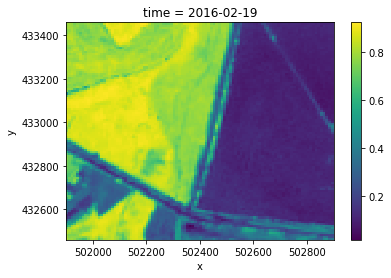

In [27]:
cubic_spline.isel(time=0).plot()

In [28]:
cubic_spline_der = build_temp_dyn(subset, xr_cubic_spline_der)
cubic_spline_der

<xarray.DataArray (time: 5, y: 100, x: 100)>
array([[[ 1.385703e-16,  1.280010e-16, ...,  2.663221e-16,  2.766099e-16],
        [ 1.625559e-16,  1.428120e-16, ...,  2.879394e-16,  2.880530e-16],
        ...,
        [ 4.501933e-17,  6.271049e-17, ..., -4.697986e-17, -2.763649e-17],
        [ 5.829727e-17,  6.719632e-17, ..., -2.739040e-17, -4.222993e-17]],

       [[-8.569694e-17, -7.646201e-17, ...,  1.200978e-16,  1.189700e-16],
        [-9.237059e-17, -9.091354e-17, ...,  1.238885e-16,  1.399339e-16],
        ...,
        [ 5.147209e-17,  5.857323e-17, ...,  2.172052e-16,  2.231601e-16],
        [ 6.582542e-17,  6.938441e-17, ...,  2.040817e-16,  2.211179e-16]],

       ...,

       [[-2.472767e-16, -2.557475e-16, ..., -2.467234e-16, -2.535912e-16],
        [-2.375470e-16, -2.391597e-16, ..., -2.630530e-16, -2.777290e-16],
        ...,
        [ 5.633723e-17,  5.751403e-17, ...,  3.147633e-17,  2.537201e-17],
        [ 5.423262e-17,  4.969530e-17, ...,  2.563008e-17,  2.960838e-17]]

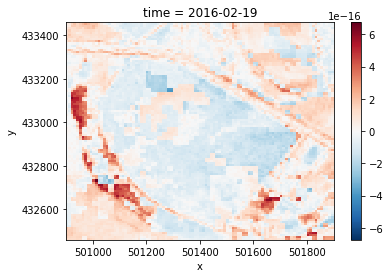

In [35]:
cubic_spline_der.isel(time=0).plot()

In [91]:
calculate_time_periods(ndvi.time.values)

[1.4544576e+18, 1.4530752e+18, 1.4516928e+18, 1.4503104e+18, 1.448928e+18]

In [94]:
ndvi.time.values.astype('d').astype('datetime64[ns]')

array(['2015-12-11T00:00:00.000000000', '2015-12-21T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-20T00:00:00.000000000', '2016-01-30T00:00:00.000000000',
       '2016-02-09T00:00:00.000000000', '2016-02-19T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [153]:
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


In [154]:
nans, x = nan_helper(subset_px.values)

In [159]:
subset_px.values[~nans]

array([0.8179647 , 0.9054125 , 0.8601575 , 0.7057843 , 0.6901729 ,
       0.87417054, 0.83899313], dtype=float32)

Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit
Future exception was never retrieved
future: <Future finished exception=AllExit()>
Traceback (most recent call last):
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/distributed/client.py", line 1357, in wait
    raise AllExit()
distributed.client.AllExit


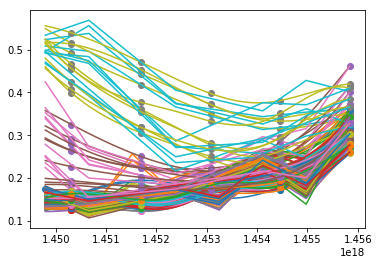

In [53]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(1, 1, 1)
ax.scatter(subset_px.time.values.astype('d'), subset_px.values)

### idea: create a map of indexes for each class. test if reduces overhead.

for x in range(10):
    for y in range(10):
        subset_px = subset.isel(x=x,y=y)
        nans = np.isnan(subset_px.values)
        spl = interpolate.CubicSpline(subset_px.time.values.astype('d')[~nans], savitzky_golay(subset_px.values[~nans], 5, 3))

        x2 = np.linspace(min(subset_px.time.values.astype('d')), max(subset_px.time.values.astype('d')), 200)
        
        y2 = spl(x2)
        
        ax.plot(calculate_time_periods(subset_px.time.values), spl(calculate_time_periods(subset_px.time.values)),
         'o', x2, y2, subset_px.time.values.astype('d')[~nans], subset_px.values[~nans])


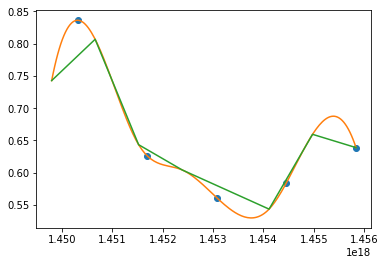

In [193]:
subset_px = subset.isel(x=4,y=3)
nans = np.isnan(subset_px.values)
spl = interpolate.CubicSpline(subset_px.time.values.astype('d')[~nans], subset_px.values[~nans])
x2 = np.linspace(min(subset_px.time.values.astype('d')), max(subset_px.time.values.astype('d')), 200)
y2 = spl(x2)
plt.plot(calculate_time_periods(subset_px.time.values), spl(calculate_time_periods(subset_px.time.values)),
         'o', x2, y2, subset_px.time.values.astype('d')[~nans], subset_px.values[~nans])
plt.show()

In [189]:
savitzky_golay(subset_px.values[~nans], 5, 3)

array([0.81084692, 0.88681737, 0.84215638, 0.71341741, 0.69490367,
       0.77763113, 0.82906842])

In [98]:
der = spl.derivative()

In [109]:
spl= interpolate.splrep(ndvi.isel(x=0,y=0).time.values.astype('d'), ndvi.isel(x=0,y=0).values)

In [110]:
spl

(array([1.449792e+18, 1.449792e+18, 1.449792e+18, 1.449792e+18,
        1.451520e+18, 1.452384e+18, 1.453248e+18, 1.454112e+18,
        1.455840e+18, 1.455840e+18, 1.455840e+18, 1.455840e+18]),
 array([ 0.81796467,  1.00501905,  0.7725508 ,  0.95788145, -0.41570333,
         1.3539148 ,  0.68909217,  0.83899313,  0.        ,  0.        ,
         0.        ,  0.        ]),
 3)

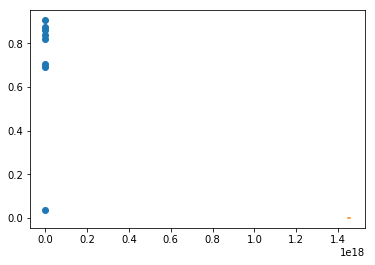

In [99]:
plot2 = der(x2)
plt.plot(ndtime, ndval, 'o', x2, plot2)
plt.show()